In [95]:
# !pip install caer canaro

In [96]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [97]:
IMG_SIZE = (80, 80)
channels = 1
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [98]:
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [99]:
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 12:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten',
 'chief_wiggum',
 'abraham_grampa_simpson']

**Create Training Data**

In [100]:
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE = IMG_SIZE, isShuffle=True) # verbose = 0 if don't want any output

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.4814035892486572s
[INFO] At 1000 files
[INFO] 1454 files found in 0.12636113166809082s
[INFO] At 1000 files
[INFO] 1452 files found in 0.1259479522705078s
[INFO] At 1000 files
[INFO] 1354 files found in 0.08199119567871094s
[INFO] At 1000 files
[INFO] 1342 files found in 0.08017206192016602s
[INFO] At 1000 files
[INFO] 1291 files found in 0.07295370101928711s
[INFO] At 1000 files
[INFO] 1206 files found in 0.03408241271972656s
[INFO] At 1000 files
[INFO] 1194 files found in 0.023692846298217773s
[INFO] At 1000 files
[INFO] 1193 files found in 0.021726608276367188s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0037276744842529297s
[INFO] 986 files found in 0.0036330223083496094s
[INFO] 913 files found in 0.0034198760986328125s
----------------------------------------------
[INFO] 15710 files prep

In [101]:
len(train)

15710

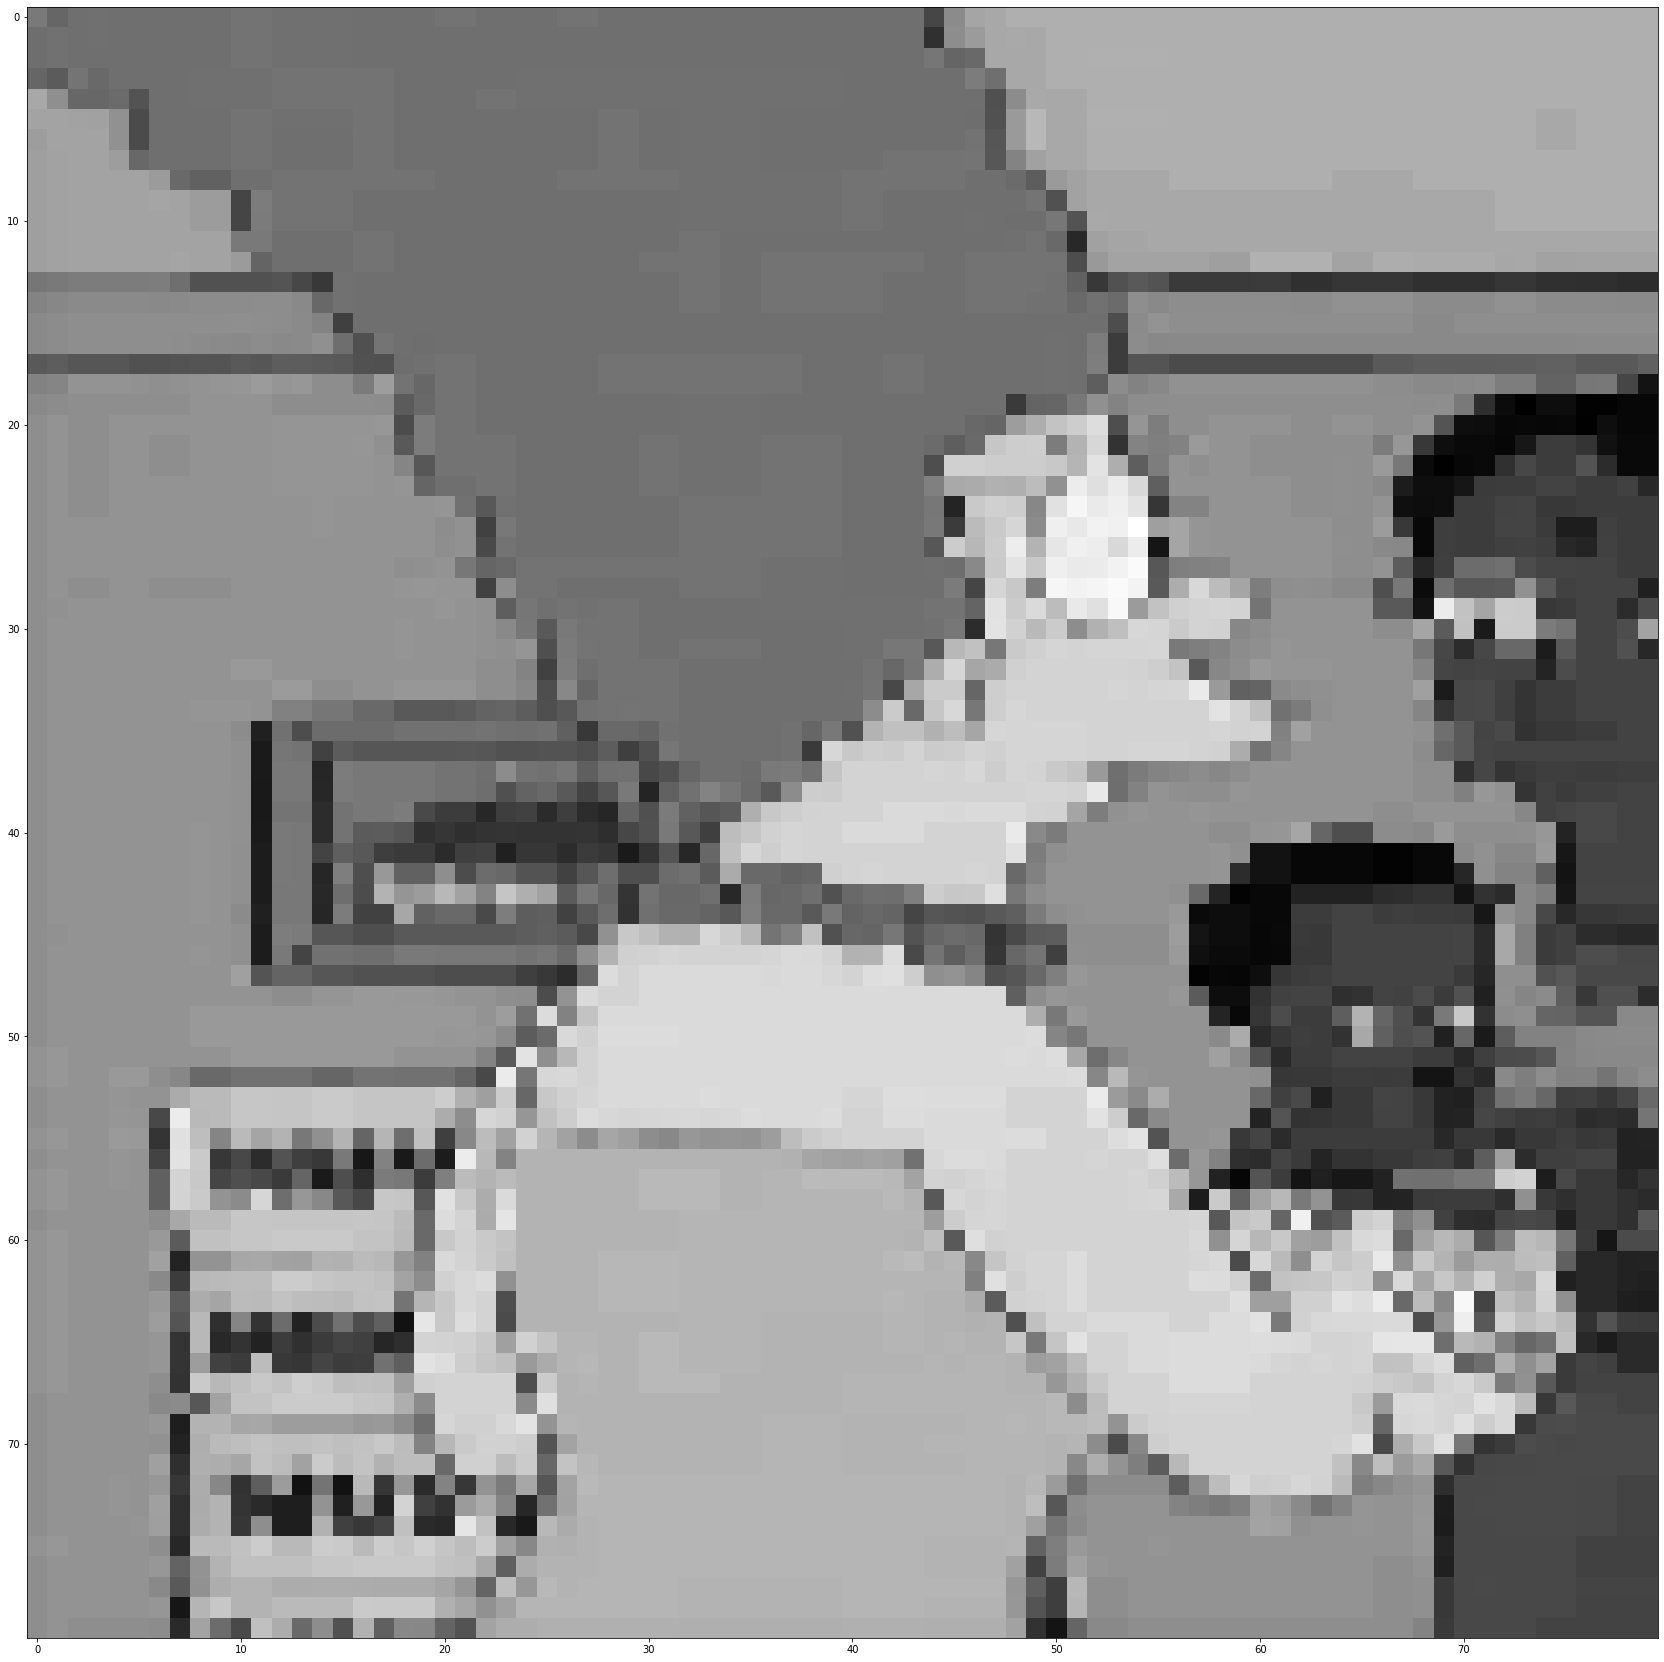

In [102]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [103]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

**Normalize the featureSet ==> (0,1)**

In [104]:
from tensorflow.keras.utils import to_categorical

featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [105]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [106]:
del train
del featureSet
del labels
gc.collect()

23

**Image Data Generator**

In [107]:
BATCH_SIZE = 32
EPOCHS = 10

In [108]:
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

**Create Model**

In [109]:
model = canaro.models.createSimpsonsModel(IMG_SIZE=IMG_SIZE, channels=channels, output_dim=len(characters),
                                         loss='binary_crossentropy', decay=1e-6, learning_rate=0.001, momentum=0.9,
                                         nesterov=True)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 80, 80, 32)        320       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 78, 78, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 39, 39, 64)        18496     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 18, 18, 64)       

In [110]:
from tensorflow.keras.callbacks import LearningRateScheduler

callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [111]:
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val, y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
392/392 [==============================] - 12s 29ms/step - loss: 0.3028 - accuracy: 0.1331 - val_loss: 0.2940 - val_accuracy: 0.1489
Epoch 2/10
392/392 [==============================] - 10s 25ms/step - loss: 0.2856 - accuracy: 0.1390
Epoch 3/10
392/392 [==============================] - 10s 26ms/step - loss: 0.2850 - accuracy: 0.1388
Epoch 4/10
392/392 [==============================] - 10s 24ms/step - loss: 0.2848 - accuracy: 0.1420
Epoch 5/10
392/392 [==============================] - 10s 26ms/step - loss: 0.2815 - accuracy: 0.1548
Epoch 6/10
392/392 [==============================] - 10s 25ms/step - loss: 0.2725 - accuracy: 0.2009
Epoch 7/10
392/392 [==============================] - 10s 25ms/step - loss: 0.2685 - accuracy: 0.2123
Epoch 8/10
392/392 [==============================] - 10s 26ms/step - loss: 0.2663 - accuracy: 0.2258
Epoch 9/10
392/392 [==============================] - 10s 25ms/step - loss: 0.2636 - accuracy: 0.2437
Epoch 10/10
392/392 [===================

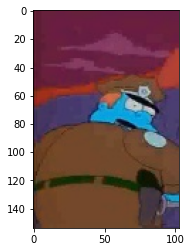

In [112]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/chief_wiggum_16.jpg'
img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [113]:
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img

In [114]:
predictions = model.predict(prepare(img))

In [115]:
print(characters[np.argmax(predictions[0])])

lisa_simpson


Lol, not really as amazing...